# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model in multiple conditions

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
from mne.decoding import UnsupervisedSpatialFilter
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()
print(cpus)

%load_ext autoreload
%autoreload 2


80


The following cells allow you to restrict the analysis to a subset of the participants. THis will ease the computational load on your machine but will be removed for the final analysis

# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events

save_file = 'epoch_data_condition-wise.nc'
if save_file not in os.listdir():#avoids to loop again if notebook is restarted
    path = 'preprocessed_data/'
    subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
    print(subj_names)
    subj_files = ['preprocessed_data/preprocessed_'+x+'.fif' for x in subj_names]
    with multiprocessing.Pool(processes=cpus) as pool:
        epoch_data = pool.starmap(hsmm.read_mne_EEG, 
                zip([[x] for x in subj_files], itertools.repeat(event_id), itertools.repeat(resp_id),
                    itertools.repeat(1024)))
    epoch_data = xr.concat(epoch_data, pd.Series(subj_names, name="participant"))#not sure about the order of the particiapnt use with caution
    epoch_data.to_netcdf(save_file)
    epoch_data = xr.open_dataset(save_file)#For an unknown reason I need to re-read it
else:
    epoch_data = xr.open_dataset(save_file)

In [3]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 2392, samples: 2046, electrodes: 64, participant: 19)
Coordinates:
  * epochs       (epochs) int32 0 1 2 3 4 5 6 ... 2386 2387 2388 2389 2390 2391
  * samples      (samples) int32 0 1 2 3 4 5 6 ... 2040 2041 2042 2043 2044 2045
  * electrodes   (electrodes) object 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * participant  (participant) object 'S8' 'S6' 'S1' 'S18' ... 'S20' 'S2' 'S5'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 ...
    event        (participant, epochs) object ...
Attributes:
    sfreq:    1024.0

# Applying HsMM for the speed condition

In [4]:
speed, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('speed'),drop=True),\
                           'participant',stack=True)

In [5]:
speed_init = hsmm.hsmm(speed.data.T, starts, ends, sf=epoch_data.sfreq)

In [6]:
if 'bests_speed.nc' not in os.listdir():
    max_estimates = speed_init.fit_single(speed_init.max_bumps())
    bump_loo_results = [max_estimates]
    i = 1
    for n_bumps in np.arange(speed_init.max_bumps()-1,0,-1):
        temp_best = bump_loo_results[-i]
        n_bumps_list = np.arange(n_bumps+1)
        possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
        possible_flats = list(itertools.combinations(n_bumps_list, n_bumps))
        possible_flats = [np.insert(x,0,0) for x in possible_flats]
        with multiprocessing.Pool(processes=cpus) as pool:
            bump_loo_likelihood_temp = pool.starmap(speed_init.fit_single, 
                zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                    temp_best.parameters.values[possible_flats,:],
                    itertools.repeat(1),itertools.repeat(True)))
                    #repeat(np.tile([1,50], (n_bumps,1))),
                    #repeat(np.tile([2,12], (n_bumps,1)))))
        models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
        bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
        i+=1
    bests_speed = xr.concat(bump_loo_results, dim="n_bumps")
    bests_speed = bests_speed.assign_coords({"n_bumps": np.arange(speed_init.max_bumps(),0,-1)})
    bests_speed = bests_speed.squeeze('iteration')
    bests_speed.to_netcdf('bests_speed.nc')
else:
    bests_speed = xr.open_dataset("bests_speed.nc")
    print('recovering previous estimation')
bests_speed

Estimating parameters for 4 bumps model


/Users/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:336: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/Users/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:342: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 4, stage: 5, params: 2, component: 10, bump: 4, samples: 1972, trial: 20943)
Coordinates:
  * n_bumps      (n_bumps) int64 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.622e+05 -1.249e+05 -1.262e+05 -1.294e+05
    parameters   (n_bumps, stage, params) float64 2.0 29.39 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.5646 0.4756 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

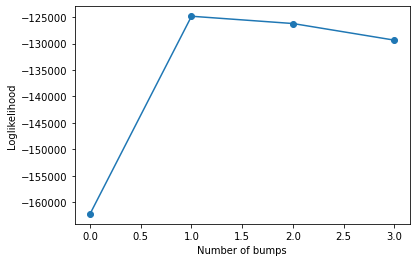

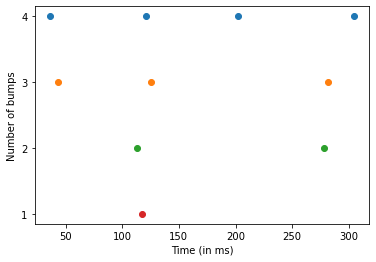

In [7]:
plt.plot(np.arange(speed_init.max_bumps()), bests_speed.likelihoods,'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(speed_init.max_bumps(),0,-1):
    times = speed_init.mean_bump_times(bests_speed.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(speed_init.max_bumps())+1)
plt.ylabel('Number of bumps');

In [12]:
#Looping over possible number of bumps
subjects_idx = epoch_data.participant.values
likelihoods_loo = []

temp = speed.unstack().transpose('samples','epochs','component','participant')
bests = bests_speed
init = speed_init


all_n_bumps = []
for n_bumps in np.arange(1,speed_init.max_bumps()+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)
    
all_n_bumps_speed = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,speed_init.max_bumps()+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})

all_n_bumps_speed.to_netcdf('all_n_bumps_speed.nc')

Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters e

TypeError: list indices must be integers or slices, not tuple

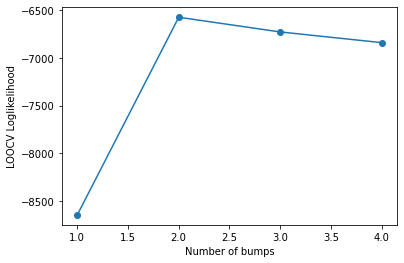

In [28]:
plt.plot(np.arange(speed_init.max_bumps(),0,-1),np.mean(np.array(all_n_bumps_speed),axis=1),'o-')
plt.ylabel('LOOCV Loglikelihood')
plt.xlabel('Number of bumps');

# Applying HsMM for the accuracy condition

In [8]:
accuracy, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('accuracy'),drop=True),\
                           'participant',stack=True)

In [9]:
accuracy_init = hsmm.hsmm(accuracy.data.T, starts, ends, sf=epoch_data.sfreq)

In [10]:
if 'bests_accuracy.nc' not in os.listdir():
    max_estimates = accuracy_init.fit_single(accuracy_init.max_bumps())
    bump_loo_results = [max_estimates]
    i = 1
    for n_bumps in np.arange(accuracy_init.max_bumps()-1,0,-1):
        temp_best = bump_loo_results[-i]
        n_bumps_list = np.arange(n_bumps+1)
        possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
        possible_flats = list(itertools.combinations(n_bumps_list, n_bumps))
        possible_flats = [np.insert(x,0,0) for x in possible_flats]
        with multiprocessing.Pool(processes=cpus) as pool:
            bump_loo_likelihood_temp = pool.starmap(accuracy_init.fit_single, 
                zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                    temp_best.parameters.values[possible_flats,:],
                    itertools.repeat(1),itertools.repeat(True)))
                    #repeat(np.tile([1,50], (n_bumps,1))),
                    #repeat(np.tile([2,12], (n_bumps,1)))))
        models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
        bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
        i+=1
    bests_accuracy = xr.concat(bump_loo_results, dim="n_bumps")
    bests_accuracy = bests_accuracy.assign_coords({"n_bumps": np.arange(accuracy_init.max_bumps(),0,-1)})
    bests_accuracy = bests_accuracy.squeeze('iteration')
    bests_accuracy.to_netcdf('bests_accuracy.nc')
else:
    bests_accuracy = xr.open_dataset("bests_accuracy.nc")
    print('recovering previous estimation')
bests_accuracy

Estimating parameters for 4 bumps model


/Users/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:336: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/Users/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:342: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 4, stage: 5, params: 2, component: 10, bump: 4, samples: 2046, trial: 20928)
Coordinates:
  * n_bumps      (n_bumps) int64 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.457e+05 -1.324e+05 -1.333e+05 -1.38e+05
    parameters   (n_bumps, stage, params) float64 2.0 52.14 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.1563 -0.1973 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

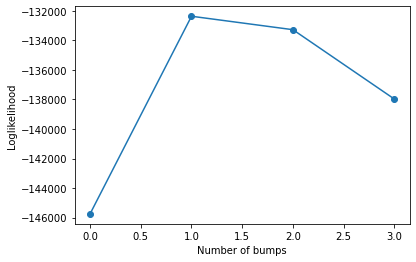

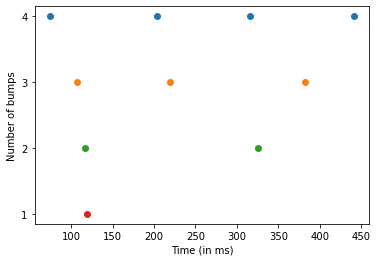

In [11]:
plt.plot(np.arange(accuracy_init.max_bumps()), bests_accuracy.likelihoods,'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(accuracy_init.max_bumps(),0,-1):
    times = accuracy_init.mean_bump_times(bests_accuracy.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(accuracy_init.max_bumps())+1)
plt.ylabel('Number of bumps');

In [ ]:
#Looping over possible number of bumps
subjects_idx = epoch_data.participant.values
likelihoods_loo = []

temp = accuracy.unstack().transpose('samples','epochs','component','participant')
bests = bests_accuracy
init = accuracy_init


all_n_bumps = []
for n_bumps in np.arange(1,speed_init.max_bumps()+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)
    
all_n_bumps_accuracy = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), 
                                    coords={"n_bump":np.arange(1,accuracy_init.max_bumps()+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})

all_n_bumps_accuracy.to_netcdf('all_n_bumps_accuracy.nc')

Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters e

In [ ]:
plt.plot(np.arange(accuracy_init.max_bumps(),0,-1),np.mean(np.array(all_n_bumps_accuracy),axis=1),'o-')
plt.ylabel('LOOCV Loglikelihood')
plt.xlabel('Number of bumps');

# Inspecting best model

In [13]:
bump3_estimates_speed = bests_speed.sel(n_bumps=3)

In [14]:
bump3_estimates_accuracy = bests_accuracy.sel(n_bumps=3)

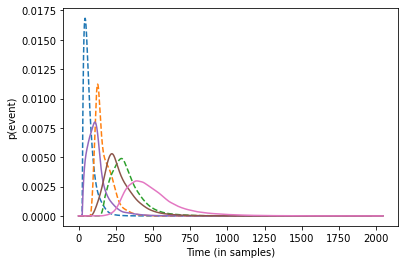

In [15]:
plt.plot(bump3_estimates_speed.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]),'--')
plt.plot(bump3_estimates_accuracy.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]))
plt.ylabel('p(event)')
plt.xlabel('Time (in samples)');

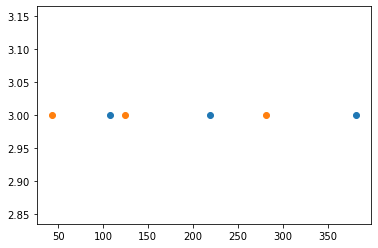

In [16]:
times = accuracy_init.mean_bump_times(bump3_estimates_accuracy)
plt.plot(times, np.repeat(3, len(times)),'o')
times = speed_init.mean_bump_times(bump3_estimates_speed)
plt.plot(times, np.repeat(3, len(times)),'o')